# Product Grouping Analysis
## Summary


## 0. Download Data

In [1]:
#import kagglehub
#import shutil
#from pathlib import Path
#
## Download the Groceries dataset
#path = kagglehub.dataset_download("psparks/instacart-market-basket-analysis")
#print("Path to dataset files:", path)
#
## Move all files to the data folder
#dataset_path = Path(path)
#for file in dataset_path.iterdir():
#    shutil.move(str(file), "./data")
#
#print("Dataset moved to current folder.")

## 1. Initialize Notebook
This section initializes the necessary packages and defines auxiliary functions.

### 1.1 Notebook Settings

In [2]:

## set transformer model 
#py_model_name = 'all-MiniLM-L6-v2' # primarily English
#py_model_name = 'paraphrase-multilingual-MiniLM-L12-v2' # multilingual
py_model_name = 'LaBSE' 
#py_model_name = 'xlm-r-100langs-bert-base-nli-stsb-mean-tokens' 

# runner ups to try, according to ChatGPT:
# - XLM-RoBERTa
# - mBART-50
# - MT5 (Multilingual T5)
# - ByT5 (handles raw text at the byte level, ideal for multilingual similarity tasks).
# - mLUKE (multilingual version of LUKE, good for named entity recognition and contextual understanding).
# - mBERT (baseline multilingual BERT, effective but less performant than XLM-R).

n_cores = 8


### 1.2 Load Packages

In [3]:
n_cores = 8

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["SIM_EMBEDDINGS_CORES"] = f"{n_cores}"

import pandas as pd
import polars as pl

import random
import pickle
import numpy as np
from tqdm import tqdm
import sentence_transformers as st

import nltk
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

import multiprocessing
multiprocessing.set_start_method("forkserver", force=True)

import torch
torch.set_num_threads(n_cores)

from collections import defaultdict


### 1.3 Globally Used Code

In [4]:
# Enable the underscore notation for polars columns, similar to ibis and dplyr (i.e., `pl.col("column_name")` -> `_.column_name`)
class PolarsColumnNamespace:
    def __getattr__(self, name):
        return pl.col(name)

# Enable _ as a shorthand for that class
_ = PolarsColumnNamespace()

## 2. Prepare Transactional Data
### 2.1 Read Transactional Data
mention that this the Kaggle instacart dataset

In [ ]:
data_dir = "data_instacart"
# aisles_df = pl.read_csv(f"./{data_dir}/aisles.csv") # contains aisle names for each aisle id
# departments_df = pl.read_csv(f"./{data_dir}/departments.csv") # contains department names for each department id
# orders_df = pl.read_csv(f"./{data_dir}/orders.csv")
products_df = pl.read_csv(f"./{data_dir}/products.csv") # contains product name, aisle id, and department id for each product id

# contains order it to product mapping, with extra info
order_products_prior_df = pl.read_csv(f"./{data_dir}/order_products__prior.csv")
order_products_train_df = pl.read_csv(f"./{data_dir}/order_products__train.csv")
order_basket_df = order_products_prior_df.vstack(order_products_train_df)

In [6]:
products_df = products_df.select(_.product_id, _.product_name)
products_df

product_id,product_name
i64,str
1,"""Chocolate Sandwich Cookies"""
2,"""All-Seasons Salt"""
3,"""Robust Golden Unsweetened Oolo…"
4,"""Smart Ones Classic Favorites M…"
5,"""Green Chile Anytime Sauce"""
…,…
49684,"""Vodka, Triple Distilled, Twist…"
49685,"""En Croute Roast Hazelnut Cranb…"
49686,"""Artisan Baguette"""


In [7]:
order_basket_df = order_basket_df.select(_.order_id, _.product_id)
order_basket_df

order_id,product_id
i64,i64
2,33120
2,28985
2,9327
2,45918
2,30035
…,…
3421063,14233
3421063,35548
3421070,35951


In [8]:
# make sure there is only one product name
products_df.group_by("product_id").len().sort("len", descending = True)

product_id,len
i64,u32
8923,1
30958,1
17581,1
14699,1
42882,1
…,…
40613,1
42060,1
13085,1


## 3. Product Description Embeddings

### 3.2 Create Description Embeddings


In [9]:
def encode_semantic_embeddings(ids, desc=None, prompt = None, fname_cache = None):
  """ """
  if not desc is None:
    desc = ids

  if (not fname_cache is None) and os.path.exists(fname_cache):
      embeddings = None
      with open(fname_cache, "rb") as f:
        embeddings = pickle.load(f)
      return embeddings

  py_model = st.SentenceTransformer(py_model_name)
  
  embeddings = py_model.encode(
      sentences = desc, 
      prompt = prompt,
      show_progress_bar = True,
      use_multiprocessing=True
      #normalize_embeddings = True # note: apparently dot products can be used instead of cosine sim, if normalized
  )

  if (not fname_cache is None):
      with open(fname_cache, "wb") as f:
          pickle.dump(embeddings, f)

  return embeddings

In [10]:
fname_dkt_embeddings = "./analysis2_embeddings_semantic.pkl"
product_ids = [str(product_id) for product_id in products_df["product_id"].to_list()]
descriptions = products_df["product_name"].to_list()
embeddings_semantic = encode_semantic_embeddings(ids = product_ids, desc = descriptions, fname_cache = fname_dkt_embeddings)

## 4. Product Co-Occurrence Embeddings

In [11]:
transactions = order_basket_df.group_by("order_id").agg(
    pl.col("product_id").cast(pl.Utf8).alias("products")
)["products"].to_list()

In [12]:
def resample_transactions(transactions):
    """Resample and shuffle transactions to create a new dataset."""
    
    # Define a lambda function to shuffle a list
    shuffle = lambda lst: random.sample(lst, k=len(lst))

    # Resample the transactions to create a new dataset
    resampled_transactions = shuffle(transactions)  # Resample with replacement
    shuffled_transactions = [shuffle(transaction) for transaction in resampled_transactions]  # Shuffle the sentences

    return shuffled_transactions

In [68]:
def encode_transactional_embeddings(product_ids, transactions, embedding_size = 100, window = 5, min_count = 1, n_bootstrap = 50, fname_cache = None):
    """ """

    if (not fname_cache is None) and os.path.exists(fname_cache):
        embeddings = None
        with open(fname_cache, "rb") as f:
            bootstrap_embeddings, embeddings = pickle.load(f)
        return np.array( embeddings )

    # Number of resamples
    bootstrap_embeddings = []

    for _ in tqdm( range(n_bootstrap) ):
        resampled_transactions = resample_transactions(transactions)  # Resample with replacement and re-shuffle the transactions
        model = Word2Vec(resampled_transactions, vector_size=embedding_size, window=window, min_count=min_count, sg=0, workers=4)
        bootstrap_embeddings.append({word: model.wv[word] for word in model.wv.index_to_key})
        
    if (not fname_cache is None):
        with open(fname_cache, "wb") as f:
            pickle.dump(bootstrap_embeddings, f)

    bootstrap_embeddings = [ defaultdict(lambda: np.zeros(embedding_size), d) for d in bootstrap_embeddings ]

    embeddings = []
    for product_id in tqdm( product_ids ):
        product_embeddings = [embedding[product_id] for embedding in bootstrap_embeddings]
        aggregated_embedding = np.mean(product_embeddings, axis=0)
        embeddings.append( aggregated_embedding )

    bootstrap_embeddings = [ dict(d) for d in bootstrap_embeddings ]
    if (not fname_cache is None):
        with open(fname_cache, "wb") as f:
            pickle.dump((bootstrap_embeddings, embeddings), f)

    return np.array( embeddings )

In [79]:
%%time
transactional_embedding_size = 100
transactional_window = 5
transactional_min_count = 1
transactional_n_bootstrap = 2

fname_dkt_embeddings = "./analysis2_embeddings_transactions.pkl"
embeddings_transactional = encode_transactional_embeddings( product_ids, transactions, embedding_size = transactional_embedding_size, 
                                                            window = transactional_window, min_count = transactional_min_count, 
                                                            n_bootstrap = transactional_n_bootstrap, fname_cache = fname_dkt_embeddings)

100%|██████████| 49688/49688 [00:00<00:00, 68451.13it/s]


CPU times: user 12min 52s, sys: 2.94 s, total: 12min 55s
Wall time: 4min 51s


## 5. Fused Embeddings


In [90]:
def normalize_embeddings(embeddings):
  """ """
  norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
  norms[norms == 0] = 1  # Prevent division by zero
  return embeddings / norms

In [91]:
norm_embeddings_semantic = normalize_embeddings(embeddings_semantic)
norm_embeddings_transactional = normalize_embeddings(embeddings_transactional)

In [92]:
embeddings = np.column_stack((norm_embeddings_semantic, norm_embeddings_transactional))

In [88]:
embeddings.shape

(49688, 868)

In [93]:
from sklearn.decomposition import PCA

n_pca_components = 868
pca = PCA(n_components=n_pca_components)
embeddings_pca = pca.fit_transform(embeddings)

In [94]:
from plotnine import *

/home/pavel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


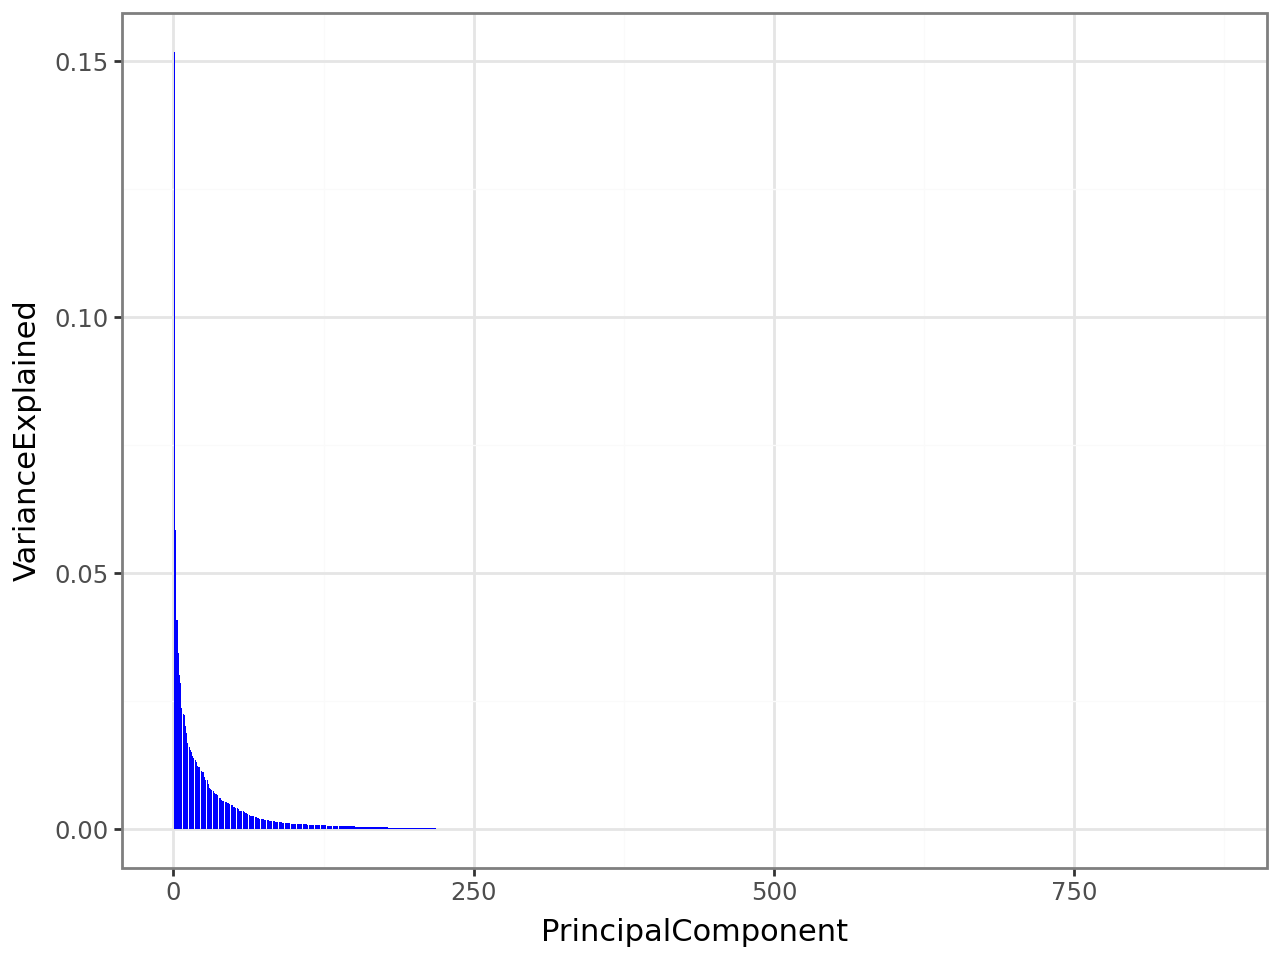

In [95]:
n_components = n_pca_components
plot_df = pd.DataFrame({'PrincipalComponent': range(1, n_components), 'VarianceExplained': pca.explained_variance_ratio_[:(n_components-1)]})
ggplot(plot_df, aes(x="PrincipalComponent", y="VarianceExplained")) + geom_bar(stat = "identity", fill = "blue") + theme_bw()

/home/pavel/.local/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 86 rows containing missing values.


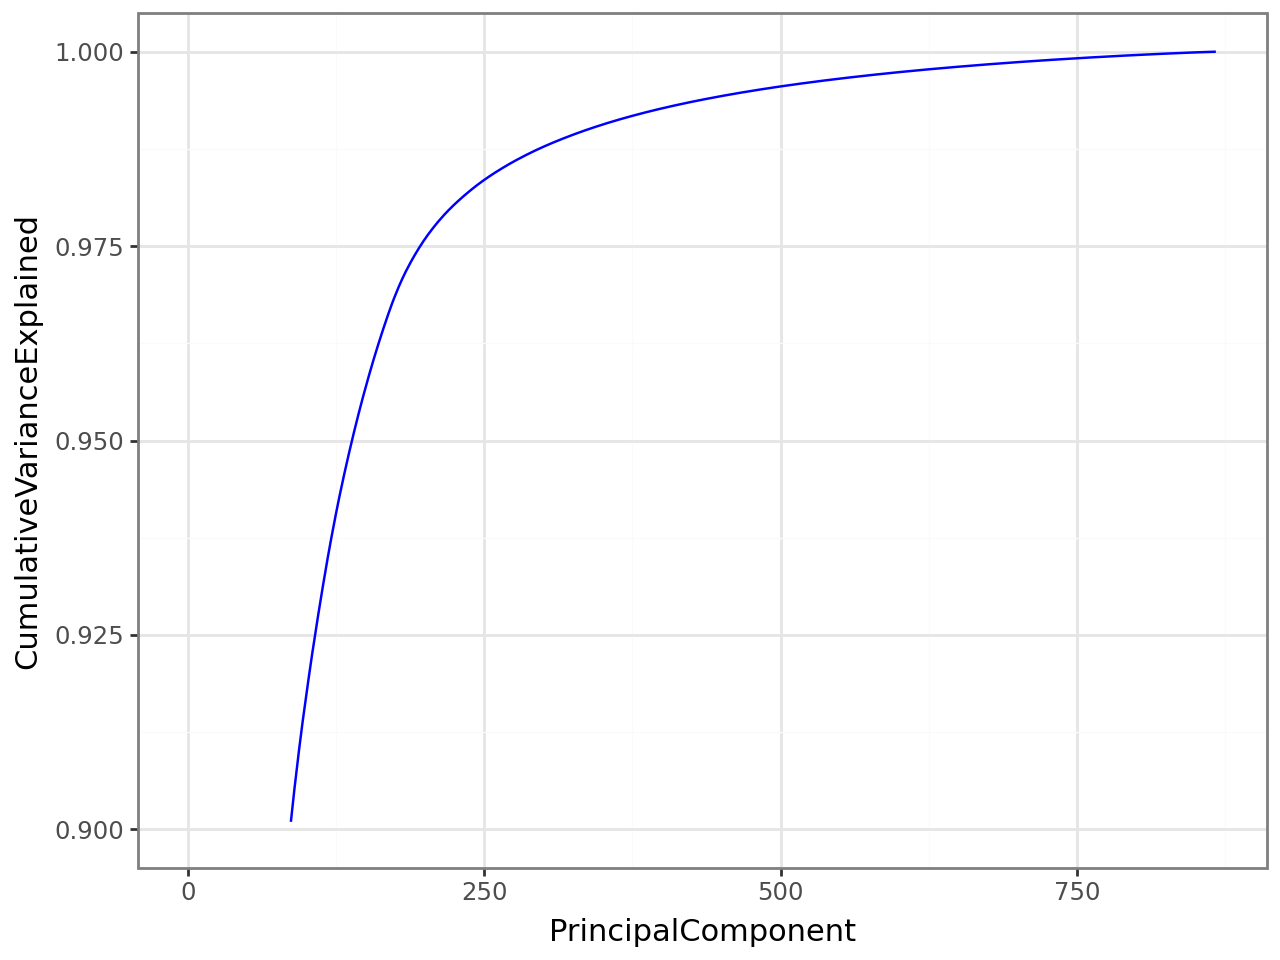

In [96]:
plot_df = pd.DataFrame({'PrincipalComponent': range(1, n_components), 'CumulativeVarianceExplained': np.cumsum(pca.explained_variance_ratio_[:(n_components-1)]) })
ggplot(plot_df, aes(x="PrincipalComponent", y="CumulativeVarianceExplained")) + geom_line(color = "blue") + theme_bw() + scale_y_continuous(limits=(0.9, 1))

## 6. Similarity Quantification


In [ ]:
sim = cosine_similarity(embeddings_pca, embeddings_pca)
distance = 1 - sim

In [ ]:
from scipy.spatial.distance import squareform
condensed_distance = squareform(distance, checks=False)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(condensed_distance, method='average')  # or 'average', 'complete', etc.

In [ ]:
import json

def build_tree(node, labels):
    if node.is_leaf():
        return {"name": labels[node.id]}
    else:
        return {
            "name": "",  # or str(node.id) if you want internal node IDs
            "children": [build_tree(node.left, labels), build_tree(node.right, labels)]
        }

root_node = to_tree(Z)
tree_json = build_tree(root_node, description)

# Optional: save to file
with open('tree.json', 'w') as f:
    json.dump(tree_json, f)

In [ ]:
import dash
import dash_cytoscape as cyto
from dash import html

def linkage_to_elements(Z):
    tree, nodes = to_tree(Z, rd=True)
    elements = []
    for node in nodes:
        elements.append({'data': {'id': str(node.id), 'label': f'{node.id}'}})
        if node.left:
            elements.append({'data': {'source': str(node.left.id), 'target': str(node.id)}})
        if node.right:
            elements.append({'data': {'source': str(node.right.id), 'target': str(node.id)}})
    return elements


from scipy.cluster.hierarchy import linkage, to_tree

elements = linkage_to_elements(Z)

app = dash.Dash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id='dendrogram',
        elements=elements,
        layout={'name': 'breadthfirst', 'spacingFactor': 2},
        style={'width': '100%', 'height': '900px'},
        minZoom=0.1,
        maxZoom=10
    )
])

app.run(debug=True)

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(12, 8))
dendrogram(Z, labels=product_ids, leaf_rotation=90)
plt.show()